In [ ]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import sys


#tensorflow_version 1.x
import tensorflow as tf

class DeepLabModel(object):
  """Class to load deeplab model and run inference."""
  
  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'concat_projection/BatchNorm/FusedBatchNorm:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)
    writer = tf.summary.FileWriter('C:/Users/oem/Documents/GitHub/crashcourse-tensorflow')
    writer.add_graph(self.sess.graph)
    
    #Εκτύπωση όλων των κόμβων του νευρωνικού δικτύου ώστε να επιλεγεί
    #το κατάλληλο layer για τα βαθιά χαρακτηριστικά
    
    #array_of_operations=(self.sess.graph.get_operations())
    # print(type(array_of_operations))
    # for i in array_of_operations:
    #   tmp=np.array(i.values())
    #   print(tmp)


  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    
    #Εύρεση deep feautures απο ενδιάμεσο στρώμα του νευρωνικού δικτύου
    deepfeats = batch_seg_map[0]
    N = deepfeats.shape[0]*deepfeats.shape[1]
    C = deepfeats.shape[-1]
    X = np.reshape(deepfeats, [N, C])

    #Ανάλυση PCA στα deep feautures της εικόνας
    Xreduced = PCA(n_components=8).fit_transform(X)

    #Κάνουμε reshape το αποτέλεσμα  του PCA ώστε να μειώσουμε τις διαστάσεις απο  8 σε 2 
    pca_res_reshaped=np.reshape(Xreduced, [deepfeats.shape[0]*deepfeats.shape[1], 8])

    #Εκτελούμε τον αλγόριθμο kmeans στο αποτέλεσμα PCA για κ=2(τμήματα)
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(pca_res_reshaped)
    
    
    #Κάνουμε reshape τα labels του kmeans ωστε να μπορέσουμε να τα προβάλουμε με τη μορφή εικόνας
    reshaped_labels=np.reshape(kmeans.labels_,[deepfeats.shape[0],deepfeats.shape[1]])
    
    
    return resized_image,reshaped_labels






def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  plt.imshow(seg_map)
  plt.axis('off')
  plt.title('K-Means result')
  
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)

MODEL_NAME = 'mobilenetv2_coco_voctrainaug'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')






def run_visualization(image_name):
  """Inferences DeepLab model and visualizes result."""
  original_im = Image.open(image_name)
  print('running deeplab on image %s...' % image_name)
  resized_im, seg_map = MODEL.run(original_im)

  vis_segmentation(resized_im, seg_map)


#5 εικόνες ως παράμετροι του script
ΙMAGES_names=["air.jpg" ,"boat.jpg" ,"cat.jpg" ,"cross.jpg", "motor.jpg"]



running deeplab on image air.jpg...
(4225,)


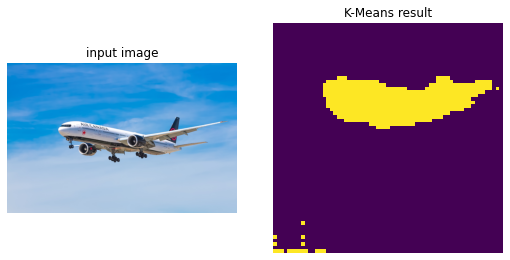

In [7]:
run_visualization(ΙMAGES_names[0])

running deeplab on image boat.jpg...
(4225,)


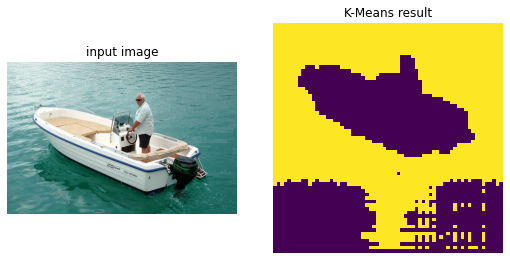

In [9]:
run_visualization(ΙMAGES_names[1])

running deeplab on image cat.jpg...
(4225,)


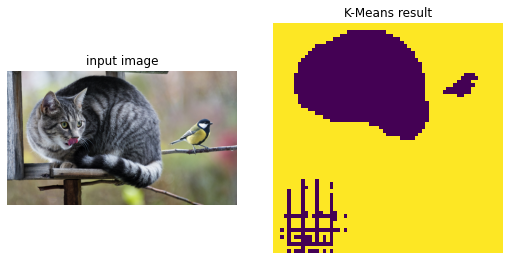

In [10]:
run_visualization(ΙMAGES_names[2])

running deeplab on image cross.jpg...
(4225,)


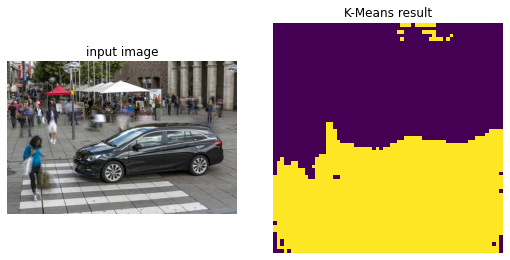

In [11]:
run_visualization(ΙMAGES_names[3])

running deeplab on image motor.jpg...
(4225,)


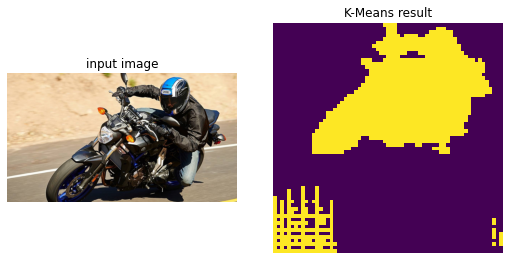

In [12]:
run_visualization(ΙMAGES_names[4])